Model the data
$$
Y\sim X_1+X_2+X_3+{\cal N}(0,1.1)
$$
and apply a regression $Y\sim X_1+X_2+X_3$ to define the coefficients. But what is we start adding more random variables $X_j\sim {\cal N}(0,1)$, $j=4,5,6,...$?

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy
from scipy import stats
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import statsmodels.formula.api as smf

Populating the interactive namespace from numpy and matplotlib


In [3]:
random.seed(2015)
X = stats.norm.rvs(0, 1, 150).reshape(50,3)
Y = X[:,0]+X[:,1]+X[:,2]
Y = Y + stats.norm.rvs(0, 1.1, 50)
data0=pd.DataFrame({'Y':Y,'X1':X[:,0],'X2':X[:,1],'X3':X[:,2]})
data0.head()
train=data0[0:19]
valid=data0[20:49]
formstr='Y ~ X1+X2+X3-1'
lm = smf.ols(formula=formstr, data = train).fit()
print(lm.summary())
r2=[lm.rsquared]
lmy2 = lm.predict(valid)
R2v=1-sum(pow(lmy2-valid.Y,2))/sum(pow(valid.Y-mean(valid.Y),2))
print('Validation R2={0}'.format(R2v))

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     23.51
Date:                Mon, 05 Oct 2015   Prob (F-statistic):           4.17e-06
Time:                        08:09:08   Log-Likelihood:                -19.542
No. Observations:                  19   AIC:                             45.08
Df Residuals:                      16   BIC:                             47.92
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
X1             1.2988      0.199      6.535      0.0

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/scipy/stats/stats.py:1205: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=19
  int(n))


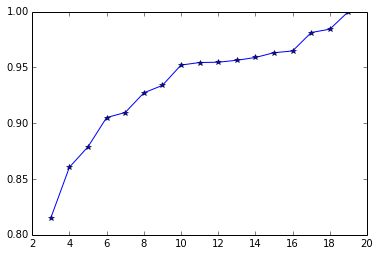

In [4]:
r2=[lm.rsquared]
for i in range(4,20):
    Xi=stats.norm.rvs(0, 1, 50)
    Xilabel='X'+str(i)
    data0[Xilabel]=Xi
    train=data0[0:19]
    valid=data0[20:49]
    formstr=formstr+'+'+Xilabel
    lm = smf.ols(formula=formstr, data = train).fit()
    r2.append(lm.rsquared)
plt.plot(range(3,20),r2,'-*')

In [5]:
lmy2 = lm.predict(valid)
R2v=1-sum(pow(lmy2-valid.Y,2))/sum(pow(valid.Y-mean(valid.Y),2))
print('Validation R2 for 20 regressors={0}'.format(R2v))

Validation R2 for 20 regressors=0.115150762337


Linear model over a high number of features might provide accurate fit (low $RSS$ and high $R^2$) on the training sample but might often:
- become too specifically adjusted to the training set (overfitting), which would reduce its generalizeability (performance on the validation/test set);\\
- lead to multicollinearity of regressors and high variance in their estimates, making coefficients hard to interpret.

## Multicollinearity

Two or more regressors appear to be highty correlated. Then estimate
$$
\hat{w}=\left(X^T X\right )^{-1}X^T Y.
$$
will suffer from having the 
$$
det(X^T X)=det(X)^2\sim 0
$$
making an estimate uncertain. For sure if $x_1=x_2$ in the regression
$$
y\sim w_1 x_1+w_2 x_2,
$$
all the fits having the same value of $w_1+w_2$ are perfectly equal, so there is no way to make a best choice of $w_1, w_2$.

In [6]:
random.seed(2002)
X1=stats.norm.rvs(0, 1, 20)
X2=X1+stats.norm.rvs(0, 0.01, 20)
Y=X1+stats.norm.rvs(0, 0.1, 20)
mdata=pd.DataFrame({'Y':Y,'X1':X1,'X2':X2})
lm = smf.ols(formula='Y ~ X1+X2-1', data = mdata).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2665.
Date:                Mon, 05 Oct 2015   Prob (F-statistic):           5.54e-23
Time:                        08:09:08   Log-Likelihood:                 22.641
No. Observations:                  20   AIC:                            -41.28
Df Residuals:                      18   BIC:                            -39.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
X1             0.0460      1.678      0.027      0.978        -3.480     3.572
X2             0.9510      1.676      0.568      0.577        -2.569     4.471
==============================================================================
Omnibus:                        1.843   Durbin-Watson:                   1.402
Prob(Omnibus):                  0.398   Jarque-Bera (JB):                1.111
Skew:                          -0.242   Prob(JB):                        0.574
Kurtosis:                       1.952   Cond. No.                         245.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 1 Feature selection

Reducing complexity of the model (number of features or their dimensionality) is usually recommended in such cases. The most streighforward way of doing so is through feature selection. 

Select a subset of the regressors of the given size $k$ maximizing the model fit ($R^2$).
Step-forward
Step-backward

Drawback - we're discarding information from the feature space.

In [7]:
def regress(mask):
    formstr='Y~-1'
    for i in range(0,len(mask)):
        if mask[i]==1:
            formstr=formstr+'+X'+str(i+1)
    lm = smf.ols(formula=formstr, data = train).fit()
    lmy2 = lm.predict(valid)
    R2=1-sum(pow(lmy2-valid.Y,2))/sum(pow(valid.Y-mean(valid.Y),2))
    #R2=1-sum(pow(lmy2-valid.Y,2))*(n-1)/sum(pow(valid.Y-mean(valid.Y),2))/(n-sum(mask)-1)
    return (R2,lm)   

In [8]:
n=19
mask0=[0]*n #initially none of the regressors are included
r20=0
while True:
    bestI=-1 #best regressor to exclude
    for i in range(0,n):
        if (mask0[i]==0):
             mask=mask0[:]
             mask[i]=1
             r2=regress(mask)[0]
             #print((i,r2,r20))
             if (r2>r20):
                 r20=r2
                 bestI=i
    if (bestI>=0):
        mask0[bestI]=1
        print((bestI,r20))
    else:
        break
(r2,lm)= regress(mask0)
lm.summary()

(1, 0.20620485284054668)
(0, 0.41105546723788433)
(2, 0.60820002115280214)
(4, 0.64423361176135341)
(7, 0.68063359224031328)
(5, 0.6898749529755237)
(17, 0.69294336619382468)
(15, 0.69401330561995667)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.783
Method:                 Least Squares   F-statistic:                     9.545
Date:                Mon, 05 Oct 2015   Prob (F-statistic):           0.000554
Time:                        08:09:10   Log-Likelihood:                -15.891
No. Observations:                  19   AIC:                             47.78
Df Residuals:                      11   BIC:                             55.34
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
X1             1.1266      0.243      4.635      0.001         0.592     1.662
X2             0.9428      0.219      4.304      0.001         0.461     1.425
X3             0.8403      0.206      4.077      0.002         0.387     1.294
X5            -0.4075      0.243     -1.680      0.121        -0.941     0.126
X6             0.1126      0.235      0.478      0.642        -0.406     0.631
X8             0.2748      0.239      1.148      0.275        -0.252     0.802
X16            0.0571      0.288      0.198      0.846        -0.576     0.690
X18           -0.0332      0.224     -0.148      0.885        -0.526     0.460
==============================================================================
Omnibus:                        2.731   Durbin-Watson:                   2.187
Prob(Omnibus):                  0.255   Jarque-Bera (JB):                1.454
Skew:                          -0.670   Prob(JB):                        0.483
Kurtosis:                       3.198   Cond. No.                         3.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# 2 Principle component analysis

Feature selection is often too rigid - we have to make our choices of keeping or getting rid of each variable entirely, though it might be the case that each regressor by itself still contains certain valuable information, but all together the feature space is redundant. As an alternative one can think of expressing our big amount of regressors through some smaller amount of latent variables (other than initial regressors) able to explain all or almost all the relevant information. This is called dimensionality reduction.

A most common linear approach to dimentionality reduction is the principal component analysis. An idea is that given $N$ observations for the $n$ regressors $x_j$

$$
X=\{x_i^j, i=1..n, j=1..N\}
$$

we try to come up with a linear transformation

$$
U=X V,
$$

where $V$ is $nxp$-dimensional transformation matrix and $U$ is a $N x p$ matrix of new factors $u_1,u_2,...,u_p$ (columns of $U$), such that they explain as much of initial information contained in $X$ as possible for the $p$ latent variables. 

## Technique

Before applying PCA variables $x_i$ are usually centered ($E[x_i]=0$) and sometimes also normalized ($var[x_i]=1$).

Selecting first principle component: look for the column unit basis $N x 1$ vector of weights/loadings $v_1$, such that resulting variable $u_1=X v_1$ has maximal possible variance $var[u_1]$:

$$
v_1=argmax_{v_1: v_1^T v_1=1}var[u_1] =argmax_{v_1: v_1^T v_1=1}u_1^T u_1=argmax_{v_1: v_1^T v_1=1}v_1^T X^T X v_1.
$$

The after first basis vector $v_1$ and principle component $u_1$ are selected, the second basis vector $v_2$ is selected following the same principle, but with an additional constrain of being orthogonal to $v_1$. 

Similarly each following $i$-th vector $v_i$ is being defined as
$$
v_i=argmax_{v_i: v_i^T v_i=1, v_i^T v_j=0, j<i}v_i^T X^T X v_i.
$$

The problem is easy to solve knowing the eigenvectors of $X^T X$, i.e. such unit vectors $v_i$ ($v_i^T v_i=1$) that

$$
\lambda_i v_i=X^T X v_i
$$

or in the matrix form

$$
diag(\lambda)V=X^T X V
$$

where $\lambda_i$ are the corresponding eigenvalues (mutually distinctive). First of all its easy to see that such vectors $v_i$ are always mutually orthogonal, as

$$
v_j^T v_i= v_j^T X^T X v_i/\lambda_i =(X^T X w_j)^T v_i/\lambda_i=v_j^T v_i \lambda_j/\lambda_i.
$$

This is why $V^T V=I_n$.

Now if we know $n$ unit eigenvectors with distinct eigenvalues such that $\lambda_1>\lambda_2> ...>\lambda_n>0$, they produce an orthogonal basis in the $n$-dimensional space and for any unit vector $w=e_1 v_1+e_2 v_2+... +e_n v_n$ we can see that

$$
w^T X^T X w=\lambda_1 e_1^2+\lambda_2 e_2^2+...+\lambda_n e_n^2,
$$

which is maximized for $e_1=1, e_2=e_3=...e_n=0$ (as $\sum_i e_i^2=1$), i.e. $w=v_1$. 

Similarly the second, third, etc loading vectors could be found as $v_2,v_3,...$ correspondingly.

Also the solution follows from the singular value decomposition of the matrix $X$:

$$
X=W \Sigma V^T,
$$

where $W$ is a $N x n$ matrix of mutually orthogonal unit columns, $V$ is a $n x n$ matrix of mutually orthogonal unit columns and $\Sigma$ is an $n x n$- diagonal matrix, i.e.

$$
W^T W=V^T V=I_n
$$

Then

$$
X^T X=V\Sigma W^T W \Sigma V^T=V\Sigma^2 V^T
$$

and its easy to see that $V$ is the matrix of eigenvectors and $\Sigma$ is the diagonal matrix of square roots of eigenvalues. Then 

$$
U=XV=W\Sigma V^T V=W\Sigma.
$$

## PCA as a dimensionality reduction tool

Now once matrixes $V, U, \Sigma$ are defined as well as the eigenvalues $\lambda_j$ (being the squares of the diagonal elements of $\Sigma$), how do we use that for dimensionality reduction? 

Matrix $V$ performs a transformation of the regressors $x_i$ to the new orthogonal variables $u_i$ being the columns of $U$. And 
$$
Var[u_i]=\lambda_i
$$

This is interpreted as each variable $u_i$ containing the fraction $\lambda_i/\sum\limits_j \lambda_j$ of the entire information (variation) contained in all the regressors. And the choice of regressors $u_i$ is such that $\lambda_1,\lambda_2,...$ are sequentially maximized. So if one wants to select as few latent variables as possible in order to cover a given franction $\alpha$ (often $95\%$) of information (variation) from it is enough to select first $k$ principle components $u_1,u_2,...u_k$, so that 

$$
\frac{\sum\limits_{i=1}^k\lambda_i}{\sum\limits_{i=1}^n\lambda_i}\geq \alpha.
$$






# 3 Real Estate Prices

Again consider prices of multiapartment houses in one of the Bronx zip codes 10466

In [2]:
REdata1 = pd.read_csv('https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab4/REzip10466.csv' , index_col=0 )
REdata1.head()

,borough,neighborhood,building_class_category,tax_class_present,block,lot,easement,building_class_present,address,apartment_number,...,land_sq_feet,gross_sq_feet,year_built,tax_class_time_sale,build_class_time_sale,sale_price,sale_date,serialid,sale_year,sale_month
4686,2,WAKEFIELD,07 RENTALS - WALKUP APARTMENTS,2B,4993,84,NaN,C1,4229 CARPENTER AVENUE,NaN,...,2752,7745,2009,2,C1,700000,2009-07-06,4686,9,6
5140,2,WILLIAMSBRIDGE,07 RENTALS - WALKUP APARTMENTS,2A,4833,15,NaN,C2,685 EAST 230 STREET,NaN,...,2867,3700,1930,2,C2,335000,2009-10-09,5140,9,9
5141,2,WILLIAMSBRIDGE,07 RENTALS - WALKUP APARTMENTS,2B,4834,14,NaN,C1,683 EAST 231ST STREET,NaN,...,3440,5250,1931,2,C1,510000,2009-10-01,5141,9,9
5146,2,WILLIAMSBRIDGE,07 RENTALS - WALKUP APARTMENTS,2A,4847,43,NaN,C2,812 EAST 223RD ST,NaN,...,2856,4082,1927,2,C2,285000,2009-11-06,5146,9,10
5147,2,WILLIAMSBRIDGE,07 RENTALS - WALKUP APARTMENTS,2A,4847,43,NaN,C2,812 EAST 223 STREET,NaN,...,2856,4082,1927,2,C2,198558,2009-05-15,5147,9,4


Regression demonstrates multicollinearity - estimates are uncertain and hard to interpret

In [3]:
lm=smf.ols(formula='sale_price~gross_sq_feet+land_sq_feet+residential_units+year_built', data = REdata1).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             sale_price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     237.0
Date:                Mon, 05 Oct 2015   Prob (F-statistic):           2.13e-55
Time:                        11:55:38   Log-Likelihood:                -1821.8
No. Observations:                 123   AIC:                             3654.
Df Residuals:                     118   BIC:                             3668.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept          -8.39e+05   6.64e+06     -0.126      0.900      -1.4e+07  1.23e+07
gross_sq_feet        15.8488     24.600      0.644      0.521       -32.866    64.564
land_sq_feet        -35.4821     18.488     -1.919      0.057       -72.092     1.128
residential_units  7.261e+04   2.34e+04      3.100      0.002      2.62e+04  1.19e+05
year_built          489.8196   3441.451      0.142      0.887     -6325.191  7304.830
==============================================================================
Omnibus:                       36.109   Durbin-Watson:                   2.348
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.775
Skew:                           0.940   Prob(JB):                     7.34e-31
Kurtosis:                       7.852   Cond. No.                     3.05e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.05e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [4]:
Y=np.matrix(REdata1.sale_price)
X=np.matrix(REdata1[['gross_sq_feet','land_sq_feet','residential_units','year_built']])

In [5]:
m=mean(X,0)
s=std(X,0)
X1=1.0*np.array(X)
for i in xrange(0,4):
    X1[:,i]=(X1[:,i]-m[0,i])/s[0,i]

In [6]:
U, s, Vt = np.linalg.svd(X1) #singular value decomposition
V = Vt.T
#sort singular values
ind = np.argsort(s)[::-1] 
U = U[:, ind]
s = s[ind]
V = V[:, ind]
S = np.diag(s)
P=X1*np.matrix(V)
print(V)

[[ 0.5801138   0.17631677  0.42208937 -0.67395915]
 [ 0.5360246  -0.07155844 -0.83719154 -0.08165381]
 [ 0.59012115  0.16558091  0.29207346  0.73418873]
 [ 0.16704084 -0.96766459  0.18879614  0.00886708]]


<Container object of 4 artists>

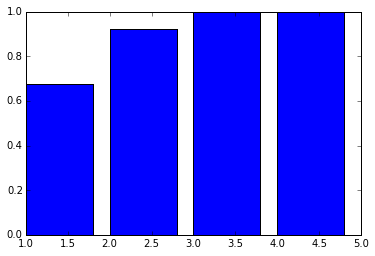

In [7]:
sc=cumsum(s**2/sum(s**2))
plt.bar(range(1,(len(sc)+1)),sc)

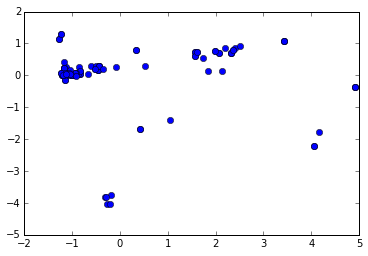

In [8]:
plt.plot(np.array(P[:,0]), np.array(P[:,1]),
        'o', color='blue', alpha=1, label='Houses_PCA')

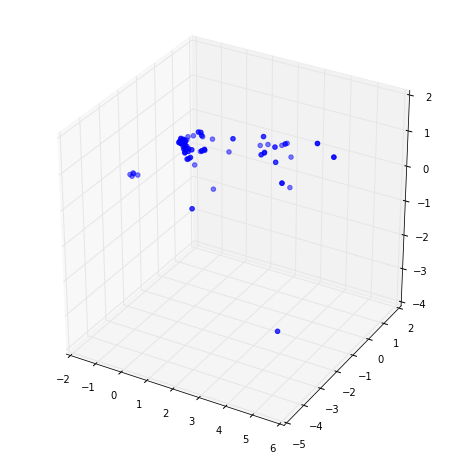

In [9]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10
ax.scatter(np.array(P[:,0]), np.array(P[:,1]), np.array(P[:,2]),
        'o', color='blue', alpha=0.5, label='PCA3')

In [10]:
np.array(REdata1.build_class_time_sale)[find((P[:,1]>-1)&(P[:,0]<1))]

array(['C2', 'C1', 'C2', 'C2', 'C2', 'C2', 'C1', 'C1', 'C2', 'C1', 'C2',
       'C1', 'C1', 'C2', 'C1', 'C1', 'C1', 'C2', 'C2', 'C1', 'C2', 'C2',
       'C1', 'C2', 'C2', 'C2', 'C1', 'C1', 'C2', 'C2', 'C1', 'C1', 'C2',
       'C2', 'C2', 'C2', 'C2', 'C1', 'C2', 'C1', 'C1', 'C1', 'C2', 'C2',
       'C2', 'C2', 'C2', 'C1', 'C1', 'C1', 'C2', 'C2', 'C1', 'C1', 'C2',
       'C2', 'C1', 'C2', 'C1', 'C1', 'C2', 'C2', 'C1', 'C2', 'C1', 'C2',
       'C1', 'C2', 'C1', 'C2', 'C2', 'C2', 'C2', 'C1', 'C2', 'C2', 'C1',
       'C1', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2', 'C2'], dtype=object)

In [11]:
np.array(REdata1.build_class_time_sale)[find((P[:,1]>-0.25)&(P[:,0]>1)&(P[:,0]<3))]

array(['C1', 'D1', 'C1', 'D1', 'D1', 'C1', 'C1', 'D3', 'D3', 'C1', 'D1',
       'D1', 'C1', 'D1', 'D1', 'D3', 'D3', 'D1', 'C1', 'C1', 'C1'], dtype=object)

In [12]:
np.array(REdata1.address)[find(P[:,1]<-3)]

array(['4229 CARPENTER AVENUE', '4150 CARPENTER AVENUE',
       '637 EAST 224TH STREET', 'BARNES AVENUE', '635 EAST 229 STREET'], dtype=object)

In [13]:
np.array(REdata1.residential_units)[find(P[:,1]<-3)]

array([ 8, 10,  8, 10,  8], dtype=int64)

In [19]:
import statsmodels.formula.api as smf
lmData=pd.DataFrame(P)
lmData.columns=['P1','P2','P3', 'P4']
lmData['Y']=Y.transpose()
lm = smf.ols(formula='Y ~ P1+P2+P3+P4',data=lmData).fit()
print(lm.summary())


                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     237.0
Date:                Mon, 05 Oct 2015   Prob (F-statistic):           2.13e-55
Time:                        11:57:53   Log-Likelihood:                -1821.8
No. Observations:                 123   AIC:                             3654.
Df Residuals:                     118   BIC:                             3668.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.677e+06   6.03e+04     27.799      0.0

# 311 data

Now let's use 311 data to provide the context of the area. And try to use this context in order to predict average level of real-estate prices

In [20]:
query = ("https://data.cityofnewyork.us/resource/3sn5-9gxz.json?"
    "$group=date,incident_zip"
    "&$select=incident_zip,date_trunc_ymd(created_date)%20AS%20date%2C%20count(*)"
    "&$order=count"
    "&$limit=50000")
data = pd.read_json(query).fillna(value=0)
data.shape

(50000, 3)

In [21]:
data.head()

,count,date,incident_zip
0,1,2013-12-30,10111
1,1,2013-12-30,11371
2,1,2013-12-30,10069
3,1,2013-12-30,60604-4134
4,1,2013-12-30,10000


In [22]:
data311 = pd.read_csv( 'https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab4/aggr311.csv' , index_col=0 )
data311.head()

,Zip,Complain,Count
1,NaN,Adopt-A-Basket,5
2,10001,Adopt-A-Basket,1
3,10003,Adopt-A-Basket,1
4,10009,Adopt-A-Basket,1
5,10010,Adopt-A-Basket,1


In [23]:
REavg=pd.read_csv('https://serv.cusp.nyu.edu/files/ADS-2015/MorningSection/lab4/REzipavg.csv', header=0)
REavg.head()

,Unnamed: 0,Zip,AvgPrice
0,6,10011,1101.373476
1,9,10014,1249.321073
2,13,10021,1055.729505
3,16,10024,809.082238
4,33,10128,1046.774838


In [24]:
import numbers
zips={}
zipsinv={}
zipnum=0
complains={}
compinv={}
compnum=0
X=numpy.zeros(shape=(1000,200))
for i in data311.index:
    z=data311.Zip[i];
    if not isinstance(z, numbers.Number):
      if z.isdigit():
        #if (int(z)>10000)& (int(z)<20000):
        if int(z) in np.array(REavg.Zip):
           if not (z in zips.keys()):
              zips[z]=zipnum
              zipsinv[zipnum]=z
              zipnum+=1
           comp=data311.Complain[i] 
           if not (comp in complains.keys()):
              complains[comp]=compnum
              compinv[compnum]=comp
              compnum+=1
           X[zips[z]][complains[comp]]=data311.Count[i]
X=X[0:zipnum,0:compnum]
Y=np.array([1.0]*zipnum)
Z=np.array([0]*zipnum)
for i in REavg.index:
    z=str(REavg.Zip[i])
    if z in zips.keys():
        Y[zips[z]]=REavg.AvgPrice[i]
        Z[zips[z]]=REavg.Zip[i]

In [25]:
for z in range(0,zipnum):
    X[z,:]=X[z,:]/sum(X[z,:])

In [26]:
random.seed(2015)
trainingind=stats.bernoulli.rvs(p = 0.67, size = len(Y))
X=matrix(X)
X1=1.0*X[trainingind==1,:]
X2=1.0*X[trainingind==0,:]
Y1=Y[trainingind==1]
Y2=Y[trainingind==0]
Z1=Z[trainingind==1]
Z2=Z[trainingind==0]

In [27]:
m=mean(X1,0)
for i in range(0,compnum):
    X1[:,i]=(X1[:,i]-m[0,i])
    X2[:,i]=(X2[:,i]-m[0,i])

In [28]:
U, s, Vt = np.linalg.svd(X1)
V = Vt.T
ind = np.argsort(s)[::-1]
U = U[:, ind]
s = s[ind]
V = V[:, ind]
S = np.diag(s)
P1=X1*np.matrix(V)
P2=X2*np.matrix(V)
P=np.concatenate((P1,P2))

<Container object of 19 artists>

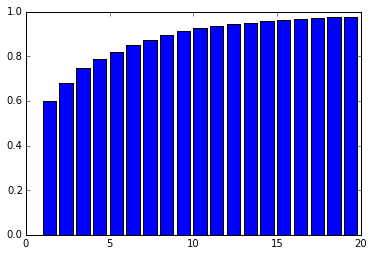

In [29]:
sc=cumsum(s**2/sum(s**2))
plt.bar(range(1,20),sc[0:19])

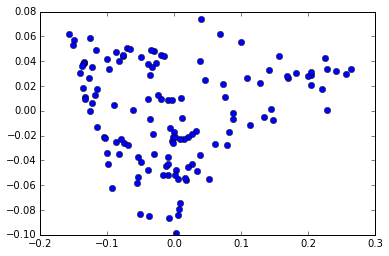

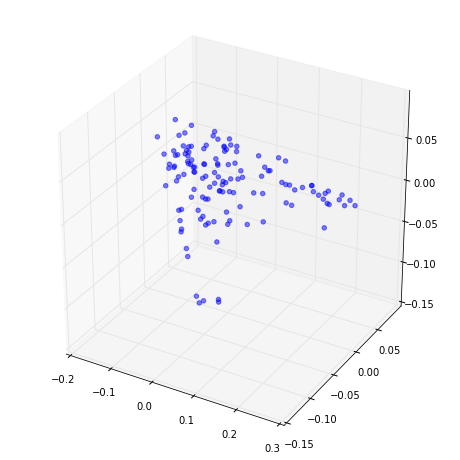

In [30]:
plt.plot(np.array(P[:,0]), np.array(P[:,1]),
        'o', color='blue', alpha=1, label='Zips_311')
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10
ax.scatter(np.array(P[:,0]), np.array(P[:,1]), np.array(P[:,2]),
        'o', color='blue', alpha=0.5, label='Zips_311')

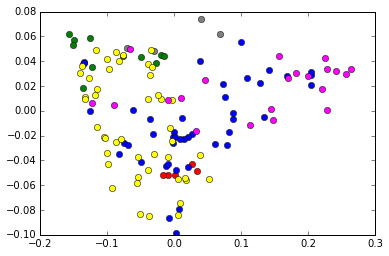

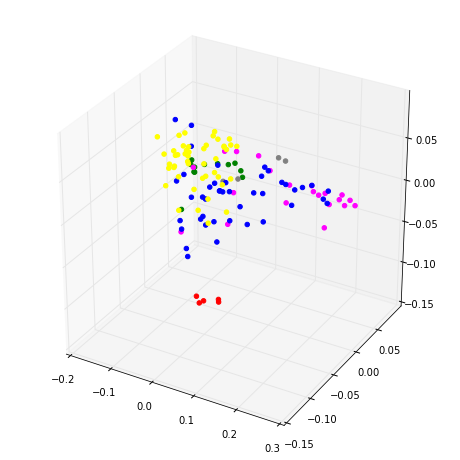

In [31]:
Z=np.concatenate((Z1,Z2))
manhattanInd=(Z>10000)&(Z<10300)&(Z!=10026)&(Z!=10027)&(Z!=10029)&(Z!=10030)&(Z!=10037)&(Z!=10038) #Manhattan
statenInd=(Z>=10300)&(Z<10400) #Staten Island
brooklynInd=(Z>=11000)&(Z<11300) #Brooklyn
queensInd=(Z>=11300)&(Z<11500) #Queens
bronxInd=(Z>=10400)&(Z<10500) #Bronx
D=Z*0 
D[manhattanInd]=1
D[statenInd]=2
D[brooklynInd]=3
D[queensInd]=4
D[bronxInd]=5

colors=('gray','red','green','blue','yellow','magenta')

for d in range(0,6):
    plt.plot(np.array(P[D==d,0]), np.array(P[D==d,1]),
        'o', color=colors[d], alpha=1)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
for d in range(0,6):
    ax.scatter(np.array(P[D==d,0]), np.array(P[D==d,1]), np.array(P[D==d,2]),
        'o', color=colors[d], alpha=1)

In [32]:
RE311train=pd.DataFrame(P1[:,0:10])
RE311train.columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']
RE311train.head()
RE311train['Y']=Y1
RE311train.head()

,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10,Y
0,-0.026962,0.038595,0.005739,-0.050208,0.009596,-0.014936,0.011240,-0.010592,0.014048,-0.002328,193.293116
1,-0.136195,0.018249,-0.055966,-0.001613,0.015849,-0.021661,0.006981,0.026480,-0.038841,-0.011825,224.736289
2,0.032539,-0.015911,0.004821,0.036528,0.004737,0.016285,-0.007509,-0.005614,0.021421,0.004742,236.452283
3,0.134154,-0.004766,0.025739,-0.011746,0.013480,-0.009847,0.004377,-0.009872,-0.006411,0.001848,217.066428
4,0.026447,-0.018494,-0.028269,-0.034681,-0.007109,0.007768,-0.007947,0.030447,-0.022373,-0.004969,193.659723


In [33]:
import statsmodels.formula.api as smf
lm = smf.ols(formula='Y ~ P1+P2+P3+P4+P5+P6+P7+P8+P9+P10', data = RE311train).fit()
print(lm.summary())
lm = smf.ols(formula='Y ~ P1+P2+P3+P5+P6+P8', data = RE311train).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:                      Y   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     18.62
Date:                Mon, 05 Oct 2015   Prob (F-statistic):           6.86e-17
Time:                        12:22:31   Log-Likelihood:                -523.46
No. Observations:                  89   AIC:                             1069.
Df Residuals:                      78   BIC:                             1096.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    310.0158      9.818     31.576      0.0

0.828143662165


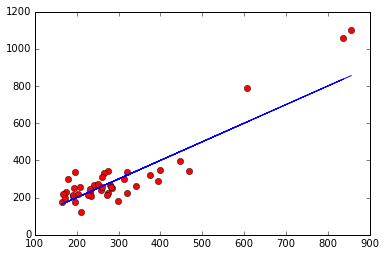

In [34]:
RE311valid=pd.DataFrame(P2[:,0:10])
RE311valid.columns=['P1','P2','P3','P4','P5','P6','P7','P8','P9','P10']
RE311valid['Y']=Y2
lmy2 = lm.predict(RE311valid)
plt.plot(lmy2,RE311valid.Y,'or')
plt.plot(lmy2,lmy2,'-b')
R2=1-sum(pow(lmy2-RE311valid.Y,2))/sum(pow(RE311valid.Y-mean(RE311valid.Y),2))
print(R2)